In [1]:
import pathlib
import platform

import pandas as pd
import numpy as np
from numpy import pi as PI
import pymc3 as pm
import theano.tensor as tt
from sklearn.preprocessing import StandardScaler, scale


import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams
import arviz as az

In [2]:
def print_versions(*pkg):
    print(f'python: {platform.python_version()}')
    for pkgi in pkg:
        print(f'{pkgi.__name__}: {pkgi.__version__}')

print_versions(pd, np, pm, az)

python: 3.7.3
pandas: 0.24.2
numpy: 1.16.4
pymc3: 3.7
arviz: 0.4.1


In [3]:
%matplotlib inline
az.style.use('arviz-darkgrid')

In [4]:
years = mdates.YearLocator(day=15, base=2)
months = mdates.MonthLocator(bymonthday=15)
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18
rcParams['axes.formatter.limits'] = (-2, 3)

In [5]:
df = pd.read_pickle('../../pickleJar/df.pkl')
#df.index.name=''
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 1997-09-01 to 2018-04-01
Data columns (total 14 columns):
sam        248 non-null float64
aao        248 non-null float64
iostz      248 non-null float64
iosostz    248 non-null float64
postz      248 non-null float64
posostz    248 non-null float64
aostz      248 non-null float64
aosostz    248 non-null float64
iopooz     241 non-null float64
popooz     188 non-null float64
aopooz     248 non-null float64
iosaaz     248 non-null float64
posaaz     248 non-null float64
aosaaz     248 non-null float64
dtypes: float64(14)
memory usage: 29.1 KB


In [6]:
d = df[['aostz']].copy()

In [7]:
d['y_stdized'] = scale(d.aostz)
d['y_max_scaled'] = d.aostz / d.aostz.max()
d.insert(0, 't', (d.index - d.index.min()) / (d.index.max() - d.index.min()))

In [8]:
d.describe()

t       aostz     y_stdized  y_max_scaled
count  248.000000  248.000000  2.480000e+02    248.000000
mean     0.501317    0.292012 -5.013910e-16      0.702983
std      0.290879    0.043535  1.002022e+00      0.104804
min      0.000000    0.199870 -2.120801e+00      0.481162
25%      0.251862    0.261736 -6.968440e-01      0.630098
50%      0.501862    0.281545 -2.409161e-01      0.677785
75%      0.752029    0.315765  5.467135e-01      0.760165
max      1.000000    0.415390  2.839748e+00      1.000000

Text(0, 0.5, 'max scaled')

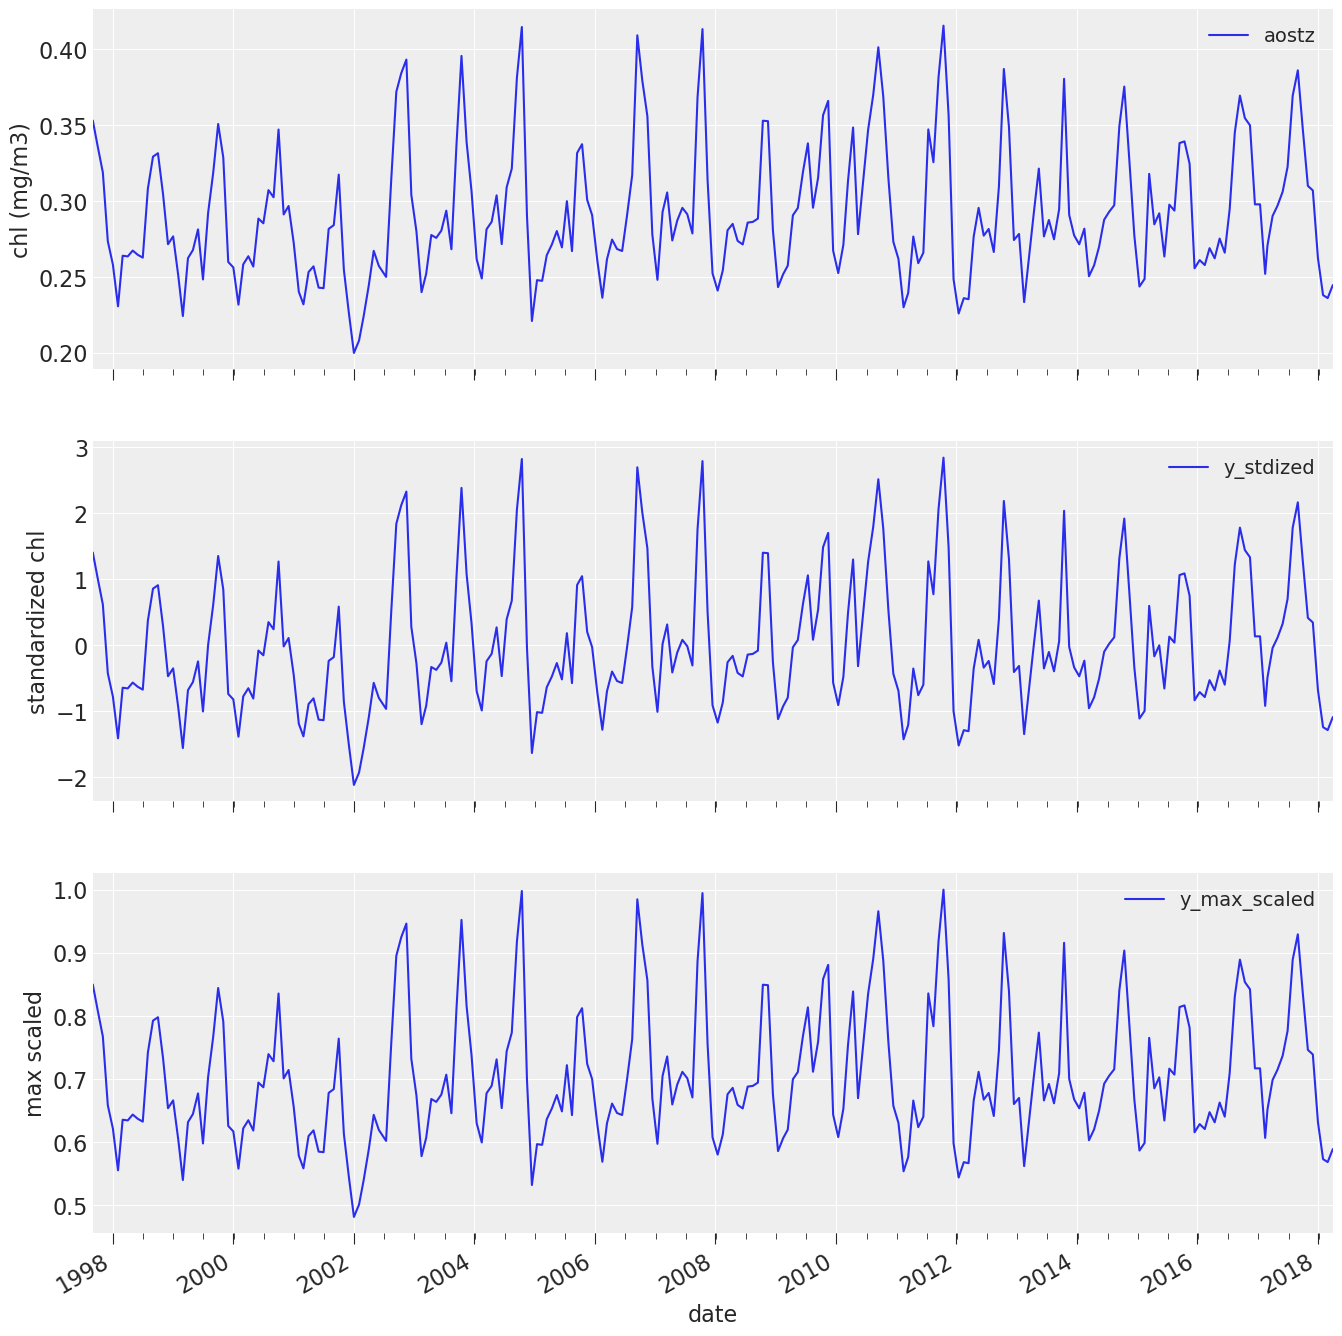

In [9]:
f, ax = pl.subplots(nrows=3, figsize=(16, 18), sharex=True)
d.plot(y='aostz', ax=ax[0])
ax[0].set_ylabel('chl (mg/m3)');
d.plot(y='y_stdized', ax=ax[1])
ax[1].set_ylabel('standardized chl')
d.plot(y='y_max_scaled', ax=ax[2])
ax[2].set_ylabel('max scaled')

In [70]:
def trend_model(m , t, n_changepoints=25, changepoints_prior_scale=0.05,
                growth_prior_scale=5, changepoint_range=0.8):
    """
    The piecewise linear trend with changepoint implementation in PyMC3.
    :param m: (pm.Model)
    :param t: (np.array) MinMax scaled time
    :param n_changepoints: (int) The number of changepoints to model.
    :param changepoint_prior_scale: (flt/None) The scale of the Laplace prior on the 
                                    delta vector.
                                    If None, a hierarchical prior is set.
    :param growth_prior_scale: (flt) The standard deviation of the prior on growth
    :param changepoint_range: (flt) Proportion of history in which trend changepoints
                                    will be estimated.
    :return g, A, s: (tt.vector, np.array, tt.vector)
    """
    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1: ]
    adj_matrix = (t[:, None] > s) * 1
    
    with m:
        # initial growth
        base_rate = pm.Normal('base_rate', 0, growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('τ', 1.5)
        
        # rate of change
        rate_adj = pm.Laplace('rate_adj', 0, changepoints_prior_scale, 
                           shape=n_changepoints)
        #offset
        base_offset = pm.Normal('base_offset', 0, 5)
        γ = -s * rate_adj
        g = (base_rate + pm.math.dot(adj_matrix, rate_adj)
            ) * t + (base_offset + pm.math.dot(adj_matrix, γ))
    return g, adj_matrix, s

# Generate a PyMC3 Model context
m_trend = pm.Model()

with m_trend:
    y, A, s = trend_model(m_trend, d['t'])
    σ = pm.HalfCauchy('σ', 0.05, testval=1)
    pm.Normal('obs', mu=y, sd=σ, observed=d['y_max_scaled'])

In [80]:
s

array([0.032, 0.064, 0.096, 0.128, 0.16 , 0.192, 0.224, 0.256, 0.288,
       0.32 , 0.352, 0.384, 0.416, 0.448, 0.48 , 0.512, 0.544, 0.576,
       0.608, 0.64 , 0.672, 0.704, 0.736, 0.768, 0.8  ])

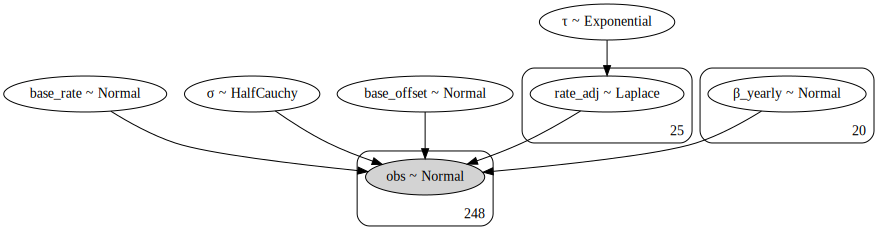

In [71]:
pm.model_to_graphviz(m)

In [72]:
def sanity_check(m, df):
    """
    :param m: (pm.Model)
    :param df: (pd.DataFrame)
    """
    # Sample from the prior and check of the model is well defined.
    y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
    pl.figure(figsize=(16, 6))
    pl.plot(y.mean(0), label='mean prior')
    pl.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0),
                    alpha=0.25, label='standard deviation')
    pl.plot(df['y_max_scaled'].values, label='true value')
    pl.legend()

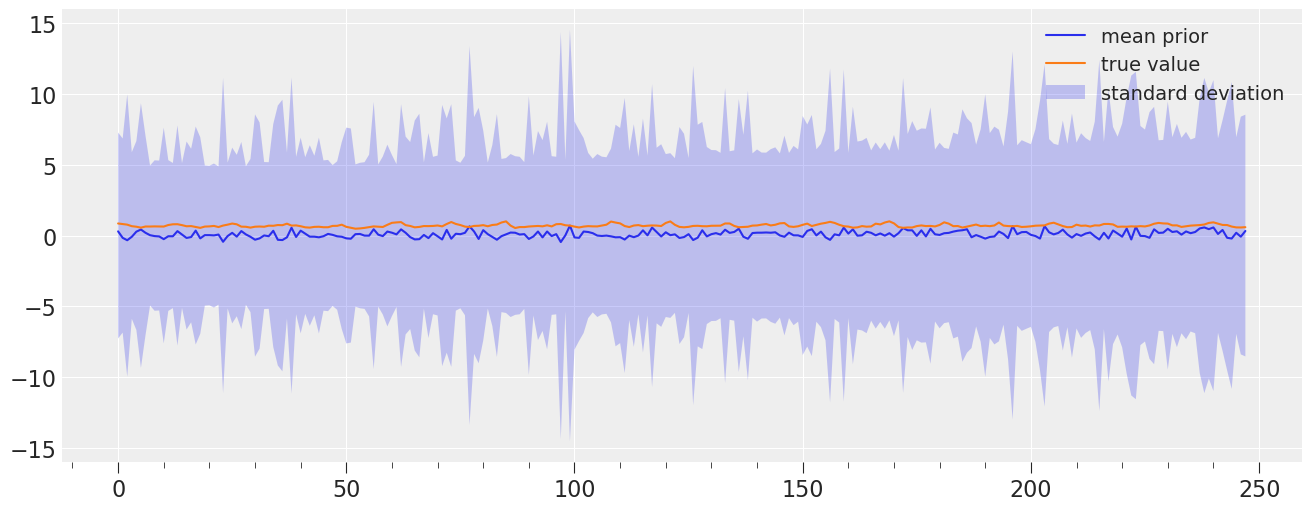

In [73]:
sanity_check(m_trend, d)

In [74]:
# Find a point estimate of the models parameters
with m_trend:
    aprox = pm.find_MAP()

/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 263.76, ||grad|| = 93.723: 100%|██████████| 248/248 [00:00<00:00, 3080.03it/s] 


In [75]:
# Find a point estimate of the models parameters
with m_trend:
    trace_trend = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, base_offset, rate_adj, base_rate]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:18<00:00, 221.11draws/s]


In [81]:
# Determine g, based on the parameters
def det_trend(k, m, δ, t, s, A):
    return (k + np.dot(A, δ)) * t + (m + np.dot(A, (-s * δ)))

# run function and rescale to original scale
g = det_trend(aprox['base_rate'], aprox['base_offset'], aprox['rate_adj'], 
              d['t'], s, A) * d.aostz.max()


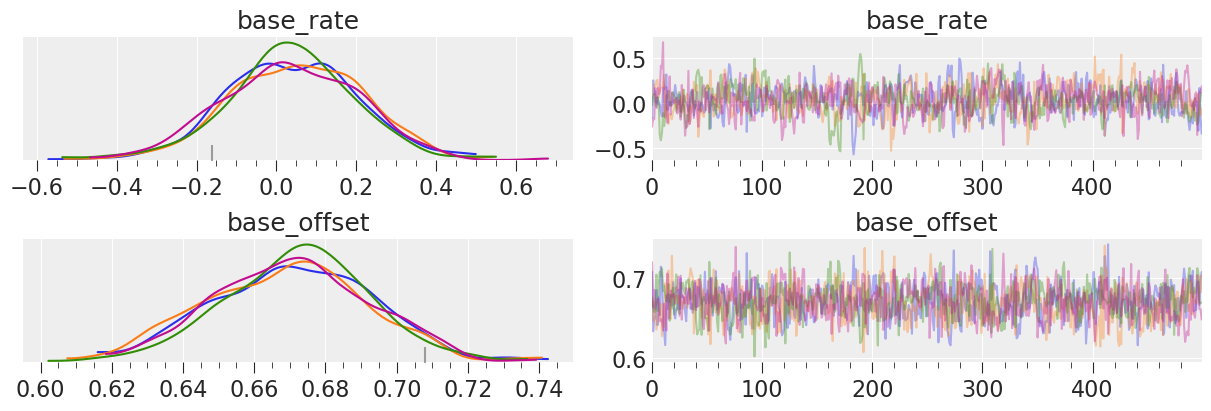

In [76]:
pm.traceplot(trace_trend, var_names=['base_rate', 'base_offset']);

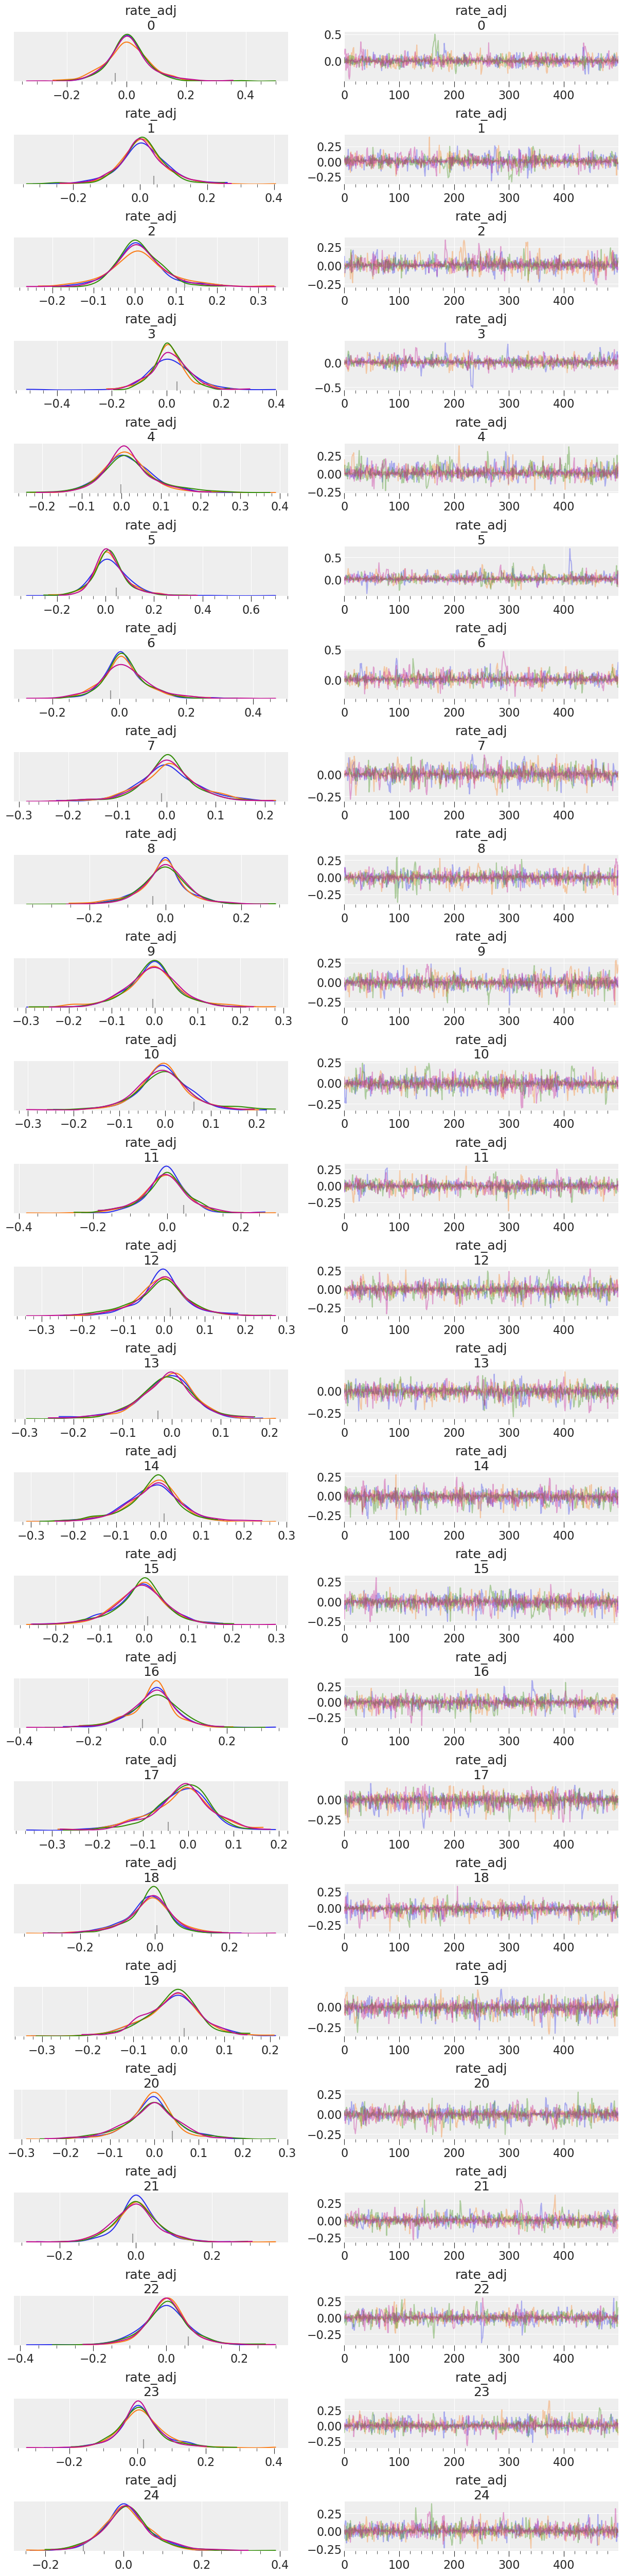

In [78]:
az.plot_trace(trace_trend, var_names=['rate_adj'], );

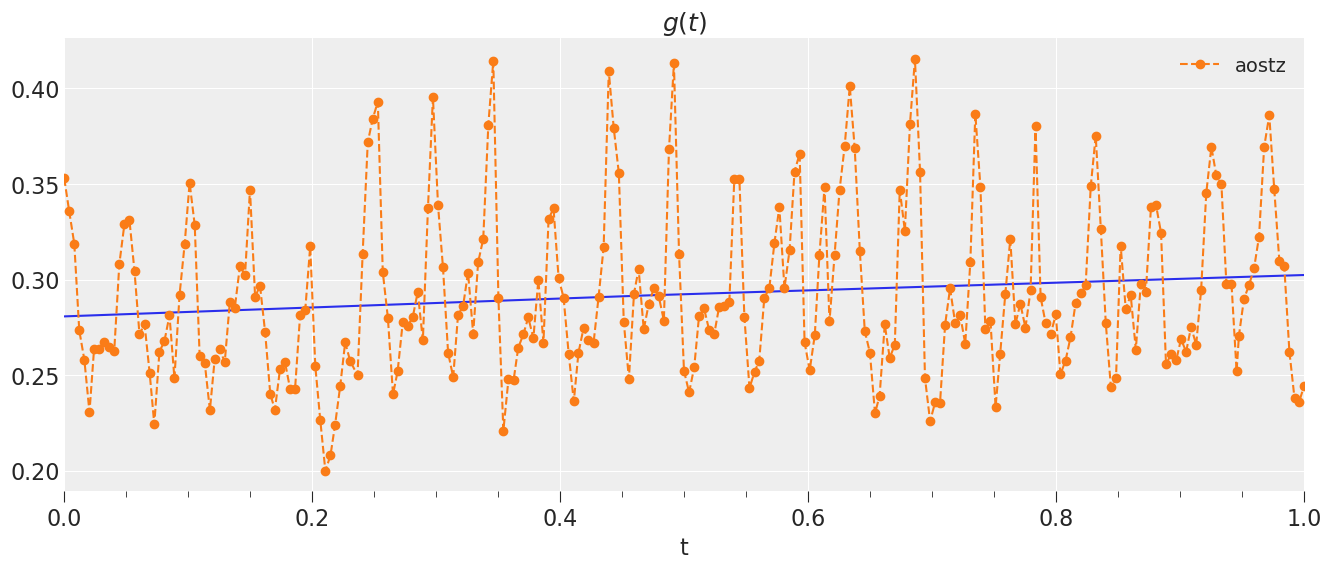

In [24]:
_, ax = pl.subplots(figsize=(16, 6))
ax.set_title('$g(t)$')
ax.plot(d.t, g)
d.plot(x='t', y='aostz', ax=ax, ls='--', marker='o')

In [82]:
aprox['rate_adj']

array([-9.41217516e-07, -2.00826653e-05, -2.56426488e-06, -3.13814850e-06,
        2.77437432e-05, -1.62260540e-06, -1.21728739e-05,  1.09251824e-06,
       -5.16637065e-06, -1.22497386e-05, -5.40443737e-06, -5.36872837e-06,
       -4.08113205e-06, -5.21324971e-03, -2.83790971e-03,  5.27648790e-05,
       -9.23812265e-06,  7.69262553e-06, -5.08529861e-05,  8.23498355e-10,
       -4.99461929e-06, -3.52916398e-07, -9.73650840e-07, -2.19095659e-06,
       -9.28386393e-06])

Adding seasonality

Using a Fourier series:
    $$s(t) = \sum^N_{n=1}\left(a_ncos(\frac{2\pi n t}{P}) + b_nsin(\frac{2\pi n t}{P})\right)$$
    
$P=12$ months in a year.

Generate matrix containing parts of eq. above for each value of t.
$$ X(t) = 
\left[cos(\frac{2\pi 1 t}{12}),...,sin(\frac{2\pi 3 t}{12})\right] $$

In [42]:
np.random.seed(6)
def fourier_series(t, p=365.25, n=10):
    x = 2 * np.pi * np.arange(1, n+1) / p
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

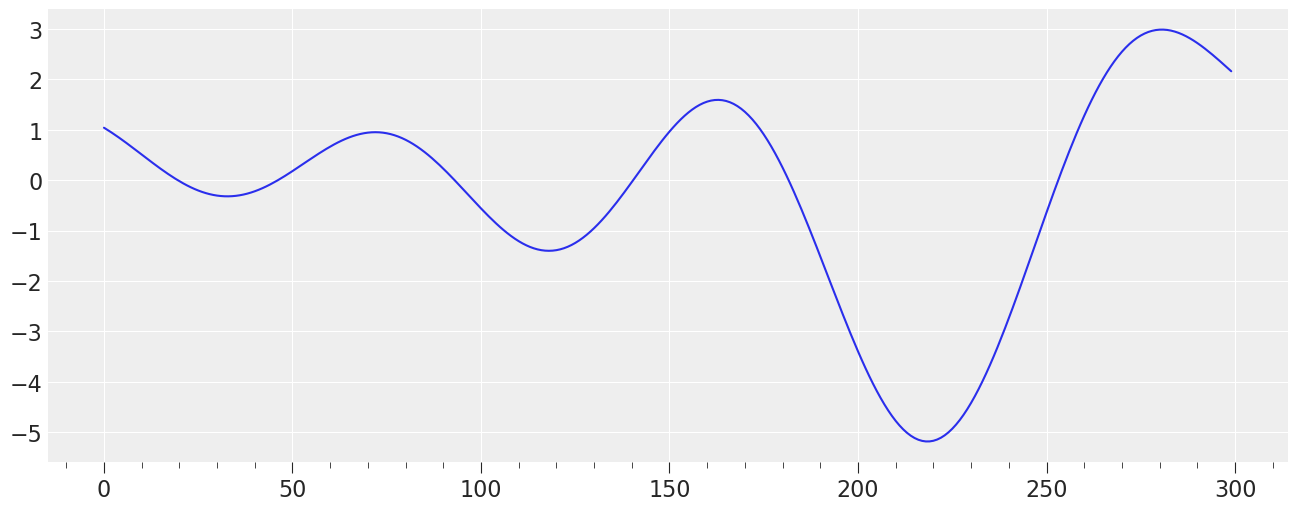

In [61]:
n = 4
t = np.arange(1000)
beta = np.random.normal(size=2 * n)
pl.figure(figsize=(16, 6))
pl.plot(fourier_series(t, n=n) @ beta)

In [66]:
x_ = fourier_series(t, p=365.25, n=10)

In [67]:
x_.shape

(300, 20)

In [62]:
a = (d.index.max() - d.index.min())

In [63]:
trend_mo

Timedelta('7517 days 00:00:00')

In [68]:
def seasonality_model(m, df, n=10, seasonality_prior_scale=10):
    # rescale the period, as t is also scaled
    p = 365.25 / (df.index.max() - df.index.min()).days
    x = fourier_series(df.t, p, n)
    with m:
        β = pm.Normal('β_yearly', mu=0, sd = seasonality_prior_scale,
                     shape=2*n)
    return x, β

m = pm.Model()

with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on τ
    μ, A, s = trend_model(m, d.t, changepoints_prior_scale=None)
    x_yearly, β_yearly = seasonality_model(m, d)
    μ += pm.math.dot(x_yearly, β_yearly)
    σ = pm.HalfCauchy('σ', 0.5, testval=1)
    obs = pm.Normal('obs', mu=μ, sd=σ, observed=d.y_max_scaled)

In [69]:
with m:
    trace=pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_yearly, base_offset, rate_adj, τ, base_rate]
Sampling 4 chains: 100%|██████████| 4000/4000 [02:03<00:00,  6.77draws/s]
There were 133 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5312953742428882, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8937299665470632, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


/accounts/ekarakoy/anaconda3/envs/southern_ocean/lib/python3.7/site-packages/arviz/plots/traceplot.py:156: SyntaxWarning: max_plots is smaller than the number of variables to plot generating only max_plots traceplots
  SyntaxWarning,


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8437eff0d0> (for post_execute):


KeyboardInterrupt: 

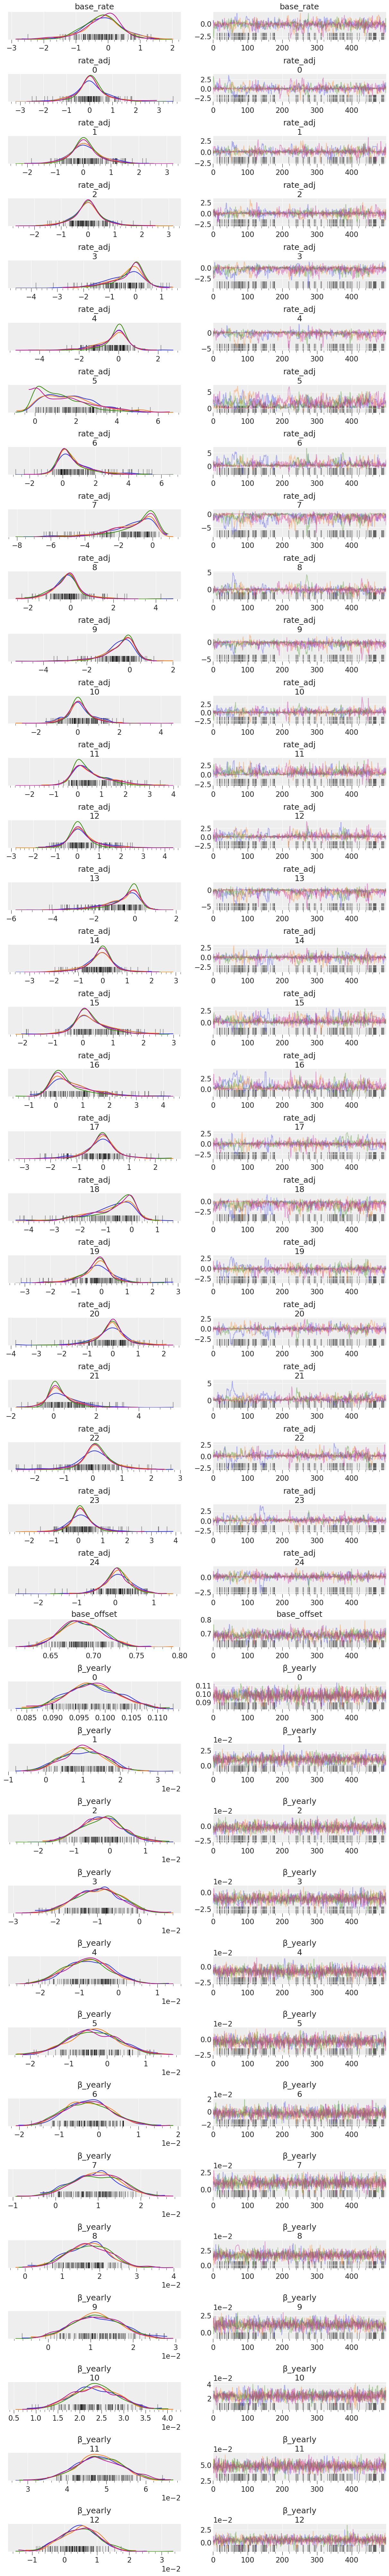

In [84]:
pm.traceplot(trace);